# **DOWNLOAD FILE**

In [ ]:
!gdown --id 1WEiWPmtvwXDYDofKzJzg75SH22UCqqOb             #lakukan download file yang akan diuji

Downloading...
From: https://drive.google.com/uc?id=1WEiWPmtvwXDYDofKzJzg75SH22UCqqOb
To: /content/kendaraan_train.csv
100% 15.2M/15.2M [00:00<00:00, 48.2MB/s]


# **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random
import copy
import math

# **EXPLORASI DATA DAN PRE-PROCESSING**

In [ ]:
#read data
df = pd.read_csv('kendaraan_train.csv')
df.head(10)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0
5,6,Pria,21.0,1.0,35.0,1.0,< 1 Tahun,Tidak,22735.0,152.0,171.0,0
6,7,Wanita,33.0,1.0,8.0,0.0,NaN,Pernah,32435.0,124.0,215.0,1
7,8,Pria,23.0,NaN,28.0,1.0,< 1 Tahun,Tidak,26869.0,152.0,222.0,0
8,9,Wanita,20.0,1.0,8.0,1.0,< 1 Tahun,Tidak,30786.0,160.0,31.0,0
9,10,NaN,54.0,1.0,29.0,0.0,> 2 Tahun,Pernah,88883.0,124.0,28.0,1


In [ ]:
#drop feature NaN
df.replace([np.nan])
df.dropna(inplace=True)
df.head(10)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
5,6,Pria,21.0,1.0,35.0,1.0,< 1 Tahun,Tidak,22735.0,152.0,171.0,0
8,9,Wanita,20.0,1.0,8.0,1.0,< 1 Tahun,Tidak,30786.0,160.0,31.0,0
10,11,Pria,25.0,1.0,14.0,1.0,< 1 Tahun,Tidak,34212.0,152.0,282.0,0
14,15,Pria,66.0,1.0,24.0,1.0,1-2 Tahun,Tidak,38616.0,145.0,281.0,0
15,16,Pria,31.0,1.0,8.0,0.0,< 1 Tahun,Pernah,2630.0,152.0,132.0,0
16,17,Wanita,24.0,1.0,30.0,1.0,< 1 Tahun,Tidak,27285.0,152.0,215.0,0
17,18,Wanita,22.0,1.0,15.0,0.0,< 1 Tahun,Pernah,38289.0,152.0,225.0,0


In [ ]:
#drop data kategorikal
x = df.drop(['id', 'SIM', 'Sudah_Asuransi', 'Jenis_Kelamin', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Tertarik'], axis=1)

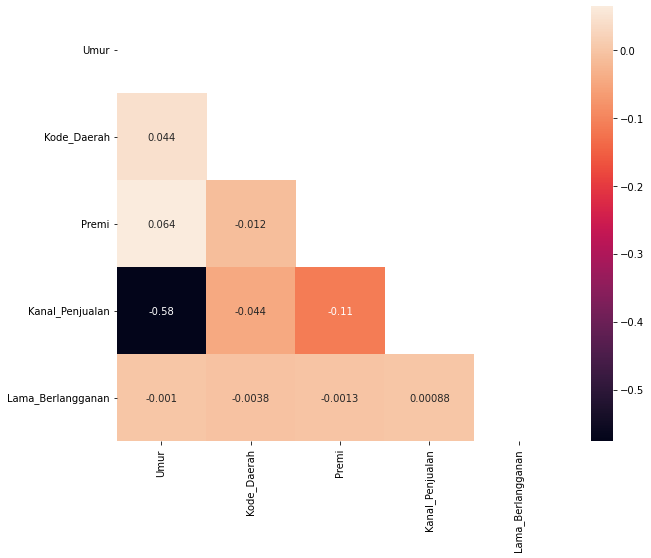

In [ ]:
#hitung korelasi
corr_x = x.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_x, dtype=bool))
sns.heatmap(corr_x, annot=True, mask=mask)

In [ ]:
#melakukan feature selection
columns = np.full((corr_x.shape[0],), True, dtype=bool)
for i in range(corr_x.shape[0]):
     for j in range(i+1, corr_x.shape[0]):
         if corr_x.iloc[i,j] >= 0.3:
             if columns[j]:
                 columns[j] = False
selected_columns = x.columns[columns]
x_t1 = x[selected_columns]
x_t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171068 entries, 0 to 285830
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur               171068 non-null  float64
 1   Kode_Daerah        171068 non-null  float64
 2   Premi              171068 non-null  float64
 3   Kanal_Penjualan    171068 non-null  float64
 4   Lama_Berlangganan  171068 non-null  float64
dtypes: float64(5)
memory usage: 7.8 MB


In [ ]:
x_coba = x[['Umur', 'Lama_Berlangganan']]

In [ ]:
x_coba.isna().sum()                           #cek apakah masih ada data kosong/NaN

Umur                 0
Lama_Berlangganan    0
dtype: int64

In [ ]:
x_train = x_coba.dropna()                     #cek apakah masih ada data kosong/NaN
x_train.isna().sum()

Umur                 0
Lama_Berlangganan    0
dtype: int64

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171068 entries, 0 to 285830
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur               171068 non-null  float64
 1   Lama_Berlangganan  171068 non-null  float64
dtypes: float64(2)
memory usage: 3.9 MB


# **OUTLIERS**

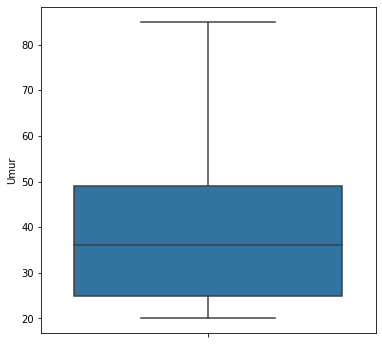

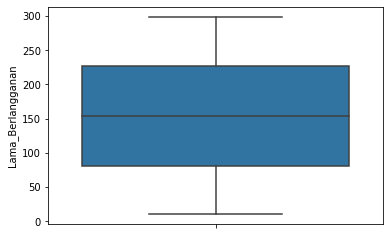

In [ ]:
plt.figure(figsize=(6, 6))
for i in x_train.columns:
  sns.boxplot(data = x_train, y = i)
  plt.show()

# **SCALING**

In [ ]:
#normalisasi korelasi dengan min-max scaling
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_train.columns = ['Umur', 'Lama_Berlangganan']
x_train

,Umur,Lama_Berlangganan
0,0.153846,0.301038
1,0.430769,0.512111
2,0.584615,0.183391
3,0.015385,0.557093
4,0.000000,0.072664
...,...,...
171063,0.046154,0.716263
171064,0.015385,0.138408
171065,0.046154,0.747405
171066,0.738462,0.899654


# **MODELLING K-MEANS**

In [ ]:
#menghitung jarak dari centroid dengan euclidean
def euclidean_dist(x, y):
    return math.sqrt(sum((x - y)**2))

In [ ]:
#untuk pemberhentian iterasi jika posisi centroid sudah stabil/tidak berubah
def is_convergent(temp_centroid, centroid, k):
    for i in range(k):
        if (temp_centroid.get(i) != centroid.get(i))[0]:
            return False

    return True

In [ ]:
#membuat fungsi untuk centroid dan cluster dengan k-means
def kmeans(k, max_iter, df):
  total = 0
  centroid = {i: df[random.randint(0, len(df))] for i in range(k)}                #inisiasi dictionary centroid untuk memilih centroid secara random
    
  temp_centroid = centroid.copy()                                                 #sebagai patokan iterasi 
    
  for _ in range(max_iter):
        cluster = {i: [] for i in range(k)}                                       #mendefinisikan dictionary cluster
        sse = []
        for x in df:                                                              #mencari nilai data terdekat dari centro
            jarak = [euclidean_dist(x, centroid[c]) for c in centroid]
            sse.append(np.min(jarak))
            cluster[jarak.index(min(jarak))].append(x)
        for cl in cluster:
            centroid[cl] = np.mean(cluster[cl], axis=0)
        if is_convergent(temp_centroid, centroid, k): 
          break

        temp_centroid = centroid.copy()

    # Mengembalikan Nilai Dari Variabel Centroid Dan Cluster
  return centroid, cluster, sum(sse)

  pada fungsi k-means ini, dilakukan inisiasi centroid untuk memilih centroid secara random. lalu dilakukan copy centroid ke temp_centroid sebagai patokan iterasi. lalu didefinisikan dictionary cluster berbentuk array yang nantinya akan diisi dengan key. 
  
  setelah itu dicari nilai data yang terdekat dengan centroid. lalu dicari nilai minimum tiap jarak menggunakan euclidean. setelah itu nilai minimum disimpan pada dictionary cluster.

  fungsi akan melakukan looping sebanyak iterasi. cek iterasi dengan is_convergent
fungsi akan mengembalikan nilai centroid dan cluster




In [ ]:
#membuat array cluster yang akan diinputkan ke k-means
def buat_cluster(cluster):
  df = []
  for key in cluster[1].keys():
        for c in cluster[1].get(key):
            df.append((c[0], c[1], key))

    # Set Array df menjadi dataframe, Menamakan nama kolom dan menampilkannya
  df = pd.DataFrame(df)
  df.columns = ['Umur', 'Lama_Berlangganan', 'Cluster']
    
  return df

In [ ]:
#Inisialisasi array Untuk SSE dan semua hasil cluster
sse_all = []
cluster_all = [] 

data = x_train.to_numpy()                           #merubah dataframe menjadi np array
max_iter = 100                                      #inisiasi nilai maks_iter dan K
K = range(2, 6)

for i in K: 
    centroid, cluster, sse = kmeans(i, max_iter, data)
    print(f'Centroid Cluster-{i}: \n{centroid}\n')
    sse_all.append(sse)                             #input setiap nilai yang di return ke array
    cluster_all.append([i, cluster, centroid])

Centroid Cluster-2: 
{0: array([0.28958303, 0.2486237 ]), 1: array([0.28943607, 0.75134836])}

Centroid Cluster-3: 
{0: array([0.61556783, 0.50919796]), 1: array([0.17966041, 0.76801678]), 2: array([0.18827646, 0.22969215])}

Centroid Cluster-4: 
{0: array([0.62338192, 0.54712225]), 1: array([0.11512312, 0.47239853]), 2: array([0.204568, 0.838926]), 3: array([0.26045754, 0.148912  ])}

Centroid Cluster-5: 
{0: array([0.56184539, 0.18908627]), 1: array([0.10326491, 0.23467388]), 2: array([0.38625767, 0.49674592]), 3: array([0.10349495, 0.76507945]), 4: array([0.56405988, 0.80616587])}



  pada bagian ini digunanakan model k-means yang telah dibuat untuk mendapatkan nilai banyak centroid, cluster, dan nilai SSE.

In [ ]:
def visualize_cluster(cluster_all):
    clusterize = []                                                               #buat array untuk menyimpan hasil klusterisasi 
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))                               #membuat subplot untuk scatterplot chart dan inisiasi awal baris dan kolom
    row = 0
    col = 0
   
    for cluster in cluster_all: 
        df = buat_cluster(cluster)                                                #buat dataframe tiap cluster dan masukkan jenis cluster untuk hitung score
        clusterize.append(df)
        colors = ['r', 'g', 'b', 'y', 'orange']
        #title plot
        axs[col, row].set_title(f'Model Dengan {cluster[0]} Cluster', fontsize=14)
        #loop tiap titik data dan centroid
        for i in range(cluster[0]):
            axs[col][row].scatter(
                df['Umur'][df['Cluster'] == i],
                df['Lama_Berlangganan'][df['Cluster'] == i],
                color=colors[i],
                label=f'Cluster {i}'
            )
            axs[col][row].scatter(cluster[2][i][0], cluster[2][i][1], color='k', marker='P')

        #untuk acuan tampilan legend centroid
        axs[col][row].scatter(cluster[2][0][0], cluster[2][0][1], color='k', label="Centroids", marker='P')                  
        #set label x, y dan tempat legend ditampilkan
        axs[col][row].legend(loc='best', bbox_to_anchor=(1, 0.5))
        #atur row dan kolom plot yang akan ditampilkan 
        row += 1
        if row == 2: row = 0
        if row == 0 and col == 0: 
            row = 0
            col = 1 
    #set label x dan y 
    for ax in axs.flat:
        ax.set(xlabel='Umur', ylabel='Lama_Berlangganan')
        ax.label_outer()
    #tampilkan plot
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.show()

    return clusterize

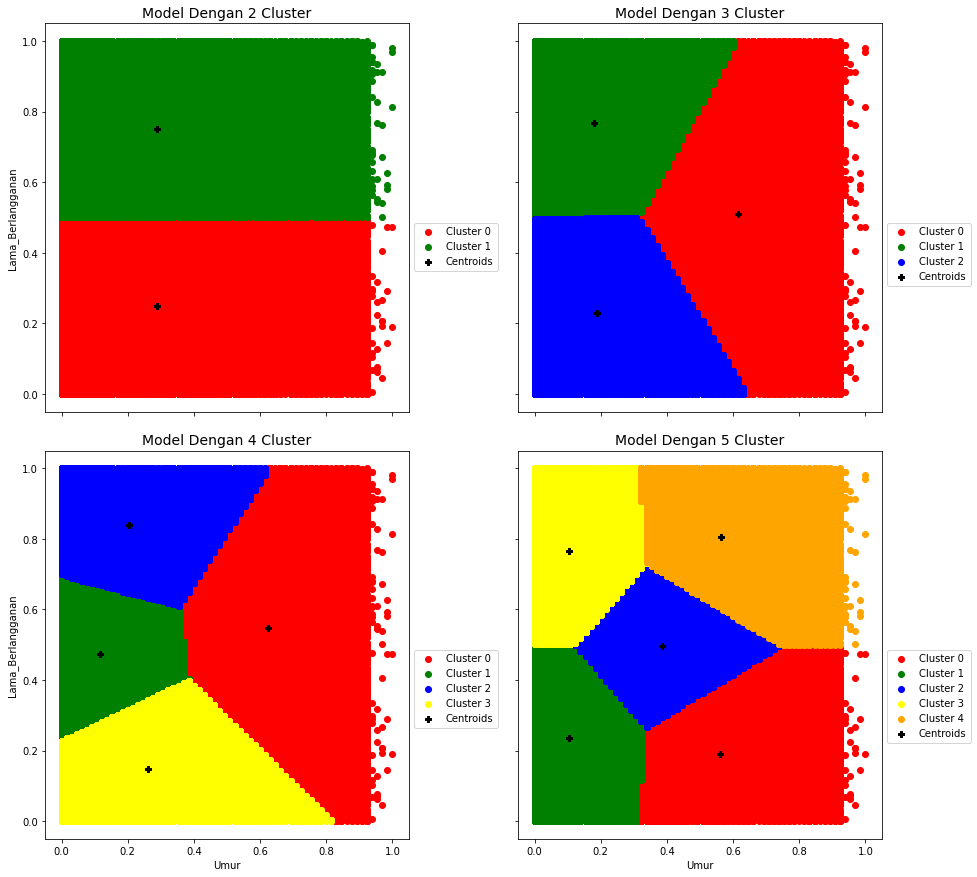

In [ ]:
clusterize = visualize_cluster(cluster_all)

# **EVALUASI DENGAN ELBOW METHOD**

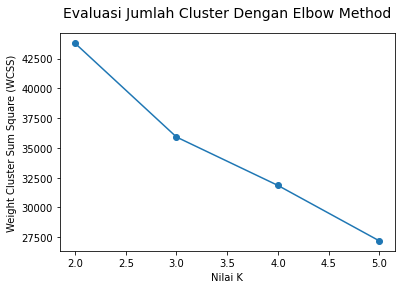

In [ ]:
# Plot data
plt.plot(K, sse_all, marker='o')
plt.xlabel('Nilai K')
plt.ylabel('SSE')
plt.title('Elbow Method', fontsize=14, pad=16)
plt.show()

# **SILHOUETTE SCORE**

In [ ]:
from sklearn.metrics import silhouette_score

for i, cluster in enumerate(clusterize):
    score = silhouette_score(cluster[['Umur', 'Lama_Berlangganan']], cluster['Cluster'])
    print(f'Cluster-{i+2}, Silhouette Score = {score}')

Cluster-2, Silhouette Score = 0.4040456690361213
Cluster-3, Silhouette Score = 0.409088273274686
Cluster-4, Silhouette Score = 0.3481708297641313
Cluster-5, Silhouette Score = 0.40486370195605154
